In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [56]:
match_url = "https://fbref.com/en/matches/7a3ab5da/Anderlecht-Gent-November-24-2024-Belgian-Pro-League"

# read the shots table (it has two header rows so ignore the first one)
shots_df = pd.read_html(match_url, attrs={"id": "shots_all"}, header=1)[0]

# drop the last 4 columns which we don't need
shots_df = shots_df.iloc[:, :-4]

# drop the empty row (shows half time)
shots_df = shots_df.dropna(subset = ["Player"])

# reset the index to avoid index issues in loops
shots_df = shots_df.reset_index(drop=True)

# sort by team (used to later pick out the team names)
shots_df.sort_values(by="Squad", inplace=True)

# convert all minutes to strings and extra time events to 45' or 90'
def parse_minute(minute):
    if '+' in minute:
        return int(minute.split('+')[0])
    else:
        return int(minute)

shots_df["Minute"] = shots_df["Minute"].apply(parse_minute)

shots_df

,Minute,Player,Squad,xG,PSxG,Outcome,Distance,Body Part,Notes
0,1,Kasper Dolberg,Anderlecht,0.09,0.00,Blocked,12.0,Right Foot,NaN
21,83,Jan-Carlo Simic,Anderlecht,0.02,0.00,Off Target,31.0,Right Foot,NaN
20,82,Anders Dreyer,Anderlecht,0.04,0.00,Off Target,26.0,Left Foot,NaN
19,80,Luis Vázquez,Anderlecht,0.48,0.90,Saved,9.0,Head,NaN
18,77,Kasper Dolberg,Anderlecht,0.71,0.98,Goal,9.0,Right Foot,Volley
16,65,Leander Dendoncker,Anderlecht,0.02,0.01,Saved,32.0,Right Foot,NaN
15,62,Samuel Edozie,Anderlecht,0.02,0.00,Off Target,20.0,Right Foot,NaN
13,59,Theo Leoni,Anderlecht,0.19,0.00,Off Target,15.0,Left Foot,NaN
12,55,Theo Leoni,Anderlecht,0.10,0.38,Saved,18.0,Left Foot,NaN
22,87,Anders Dreyer,Anderlecht,0.10,0.12,Saved,11.0,Left Foot,NaN


In [158]:
# get team names
home_team = shots_df['Squad'].iloc[0]
away_team = shots_df['Squad'].iloc[-1]

# create df for each team
def df_for_team(team_name: str, og_df: list):
   df = og_df[og_df['Squad'] == team_name].copy()
   df.sort_values(by="Minute", inplace=True)
   df['cum_xg'] = df['xG'].cumsum()
   start_row = pd.DataFrame({
      "Minute": [0],
      "xG": [0],
      "cum_xg": [0]
   })
   end_row = pd.DataFrame({
      "Minute": [90],
      "xG": [df['cum_xg'].iloc[-1]],
      "cum_xg": [df['cum_xg'].iloc[-1]]
   })
   df = pd.concat([start_row, df, end_row]).sort_values(by="Minute").reset_index(drop=True)
   
   return df

home_df = df_for_team(home_team, shots_df)
away_df = df_for_team(away_team, shots_df)

# create goal df for each team
home_goal_df = home_df[home_df['Outcome'] == "Goal"].copy().reset_index(drop=True)
away_goal_df = away_df[away_df['Outcome'] == "Goal"].copy().reset_index(drop=True)

# issue: owngoals don't show up in shots table on fbref
new_record = {
    "Minute": 85,
    "Player": "Tiago Araújo (OG)",
    "Squad": "Anderlecht",
    "Outcome": "Own Goal",
    "cum_xg": 2.82
}
home_goal_df.loc[len(home_goal_df)] = new_record

# totals
home_total_xg = round(home_df['cum_xg'].iloc[-1], 2).astype(str)
away_total_xg = round(away_df['cum_xg'].iloc[-1], 2).astype(str)
home_total_goals = len(home_goal_df)
away_total_goals = len(away_goal_df)

away_df

,Minute,xG,cum_xg,Player,Squad,PSxG,Outcome,Distance,Body Part,Notes
0,0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21,0.06,0.06,Archie Brown,Gent,0.27,Saved,21.0,Right Foot,NaN
2,25,0.05,0.11,Mathias Delorge,Gent,0.31,Saved,23.0,Left Foot,NaN
3,36,0.02,0.13,Omri Gandelman,Gent,0.00,Woodwork,11.0,Head,NaN
4,54,0.02,0.15,Max Dean,Gent,0.00,Blocked,21.0,Right Foot,NaN
5,60,0.03,0.18,Tiago Araújo,Gent,0.39,Saved,25.0,Left Foot,NaN
6,65,0.02,0.20,Archie Brown,Gent,0.19,Saved,22.0,Left Foot,NaN
7,90,0.20,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


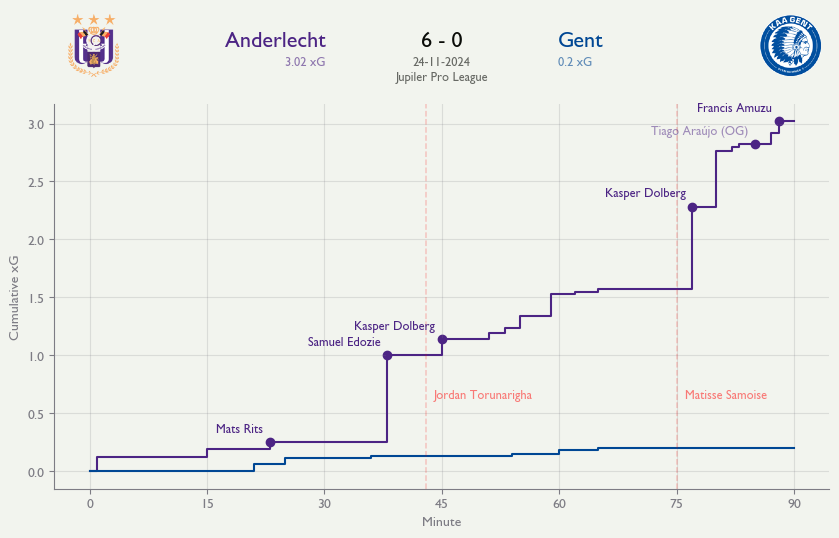

In [189]:
# colors
background_color = "#f2f4ee"
black_color = "#0a0c08"
grey_color = "#7D7C84"

# init flowchart
fig, ax = plt.subplots(figsize = (10, 5))
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
plt.rcParams['font.family'] = 'Gill Sans'
plt.rcParams.update({
    'text.color': black_color,
    'axes.labelcolor': grey_color,
    'axes.edgecolor': grey_color,
    'xtick.color': grey_color,
    'ytick.color': grey_color,
    'grid.color': grey_color,
})

# team data
home_color = "#4c2484"
home_logo = mpimg.imread("logo-rsca.png")

away_color = "#004794"
away_logo = mpimg.imread("logo-gent.png")

# plt customizations
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel("Minute")
plt.ylabel("Cumulative xG")
plt.grid(True, alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# display the team names and score
ax.text(0.35, 1.15, home_team, color=home_color, fontsize=16, ha='right', transform=ax.transAxes)
ax.text(0.5, 1.15, f"{home_total_goals} - {away_total_goals}", fontsize=16, ha='center', transform=ax.transAxes)
ax.text(0.65, 1.15, away_team, color=away_color, fontsize=16, ha='left', transform=ax.transAxes)

# game information
ax.text(0.5, 1.10, "24-11-2024", alpha=0.6, fontsize=9, ha="center", transform=ax.transAxes)
ax.text(0.5, 1.06, "Jupiler Pro League", alpha=0.6, fontsize=9, ha="center", transform=ax.transAxes)

# logo's
home_imagebox = OffsetImage(home_logo, zoom=0.45)
home_ab = AnnotationBbox(home_imagebox, (0.05, 1.15), xycoords='axes fraction', frameon=False)
ax.add_artist(home_ab)
away_imagebox = OffsetImage(away_logo, zoom=0.45)
away_ab = AnnotationBbox(away_imagebox, (0.95, 1.15), xycoords='axes fraction', frameon=False)
ax.add_artist(away_ab)

# xG for teams
ax.text(0.35, 1.10, f"{home_total_xg} xG", color=home_color, alpha=0.6, fontsize=9, ha='right', transform=ax.transAxes)
ax.text(0.65, 1.10, f"{away_total_xg} xG", color=away_color, alpha=0.6, fontsize=9, ha='left', transform=ax.transAxes)

# xG steps
ax.step(x = home_df["Minute"], y = home_df["cum_xg"], where="post", color=home_color)
ax.step(x = away_df["Minute"], y = away_df["cum_xg"], where="post", color=away_color)

# goals
ax.scatter(x = home_goal_df["Minute"], y = home_goal_df["cum_xg"], marker="o" ,color=home_color)
ax.scatter(x = away_goal_df["Minute"], y = away_goal_df["cum_xg"], marker="o" ,color=away_color)

# annotate goals
def annotate_goals(goal_df: list):    
  for i, name in goal_df['Player'].items():
      # check if it's an own goal and set alpha accordingly
      is_own_goal = goal_df['Outcome'].iloc[i] == 'Own Goal'
      alpha_value = 0.5 if is_own_goal else 1

      ax.annotate(
        name,
        (goal_df['Minute'].iloc[i], goal_df['cum_xg'].iloc[i]),
        xycoords='data',
        ha='right',
        xytext=(-5, 7.5),
        textcoords='offset points',
        color=home_color,
        fontsize=9,
        alpha=alpha_value
      )
annotate_goals(home_goal_df)
annotate_goals(away_goal_df)


# add red cards
red_cards = [
    {"Minute": 43, "Player": "Jordan Torunarigha"},
    {"Minute": 75, "Player": "Matisse Samoise"}
]

for red_card in red_cards:
    minute = red_card["Minute"]
    player_name = red_card["Player"]
    
    # add vertical line
    ax.axvline(x=minute, color="red", linestyle="--", linewidth=1.1, alpha=0.2)
    
    # annotate the line
    ax.text(
        x=minute + 1, y= 0.63,
        s=player_name,
        color="red",
        fontsize=9,
        ha='left',
        alpha= 0.5
    )

fig.savefig(
   "xg_plot-rsca-gent-24-11-2024.png", 
   dpi=300,
   bbox_inches="tight",
   format="png"
)